In [53]:
import numpy as np
import scipy as sp


def rk4(f, h, t, y, *args):
    h2 = h*0.5
    k1 = f(t, y, *args)
    k2 = f(t+h2, y+h2*k1, *args)
    k3 = f(t+h2, y+h2*k2, *args)
    k4 = f(t+h, y+h*k3, *args)
    return y + h*(k1 + 2.0*(k2+k3) + k4)/6.0

def care(A, B, Q, R):
    X = sp.linalg.solve_continuous_are(A, B, Q, R)
    K = np.linalg.solve(R, B.T@X)
    return K
    
def lqr(A, B, Q, R):
    return care(A, B, Q, R)

def lqe(A, C, Vd, Vn):
    return care(A.T, C.T, Vd, Vn).T


g = 10.0
l = 2.0
m = 1.0
M = 5.0
d = 1.0

A = np.array([[0.0,    1.0,         0.0, 0.0],
              [0.0,   -d/M,       m*g/M, 0.0],
              [0.0,    0.0,         0.0, 1.0],
              [0.0, -d/M/l, (m+M)*g/M/l, 0.0]])

B = np.array([[0.0], [1.0/M], [0.0], [1.0/M/l]])
Q = np.eye(4)
R = 0.000001*np.eye(1)
K = lqr(A, B, Q, R)

C = np.array([[1.0, 0.0, 0.0, 0.0]])
Vd = 0.04*np.eye(4)
Vn = 0.0002*np.eye(1)
Kf = lqe(A, C, Vd, Vn)


def f(t, x, u, dd):
    sinQ = np.sin(x[2])
    cosQ = np.cos(x[2])
    ddx = (m*g*sinQ*cosQ - m*l*x[3]*x[3]*sinQ - d*x[1] + u[0])/(M + m - m*cosQ*cosQ)
    ddQ = (ddx*cosQ + g*sinQ)/l
    return np.array([x[1], ddx, x[3], ddQ]) + dd

def kf(t, x, u, ym):
    return (A - Kf@C)@x + Kf@ym + B@u

ref = np.array([1.0, 0.0, 0.0, 0.0])
y0 = np.array([-1.0, 0.0, 0.1, 0.0])

ys = [y0]
yfs = [y0]
us = []
yms = []

T = 10
dt = 0.001
ts = [0.0]

while ts[-1] < T:
    u = K@(ref - yfs[-1])
    vd = np.sqrt(Vd)@np.random.normal(scale=1, size=(4,))
    y = rk4(f, dt, ts[-1], ys[-1], u, vd)

    vn = (np.sqrt(Vn)*np.random.normal(scale=1))[0]
    ym = C@ys[-1] + vn
    yf = rk4(kf, dt, ts[-1], yfs[-1], u, ym)
    
    us.append(u[0])
    ys.append(y)
    yms.append(ym)
    yfs.append(yf)
    ts.append(ts[-1]+dt)

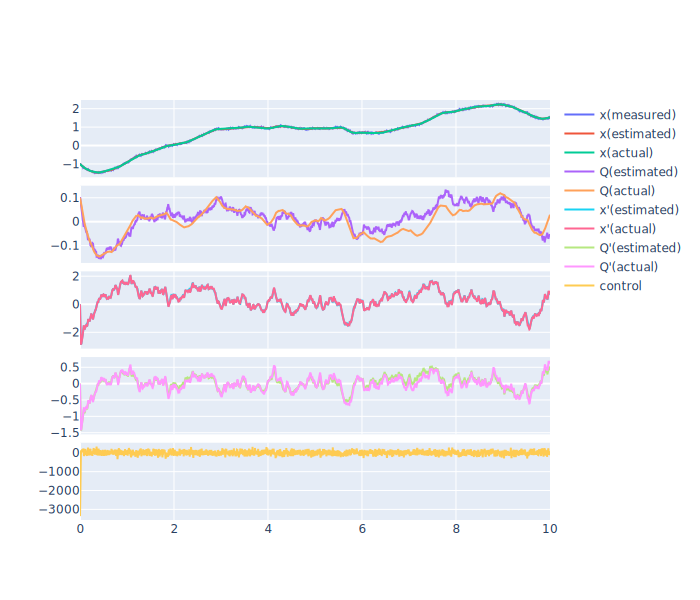

In [54]:
import plotly.graph_objects as go


t = np.hstack(ts)
y = np.vstack(ys).T
ym = np.vstack(yms)[:,0]
yf = np.vstack(yfs).T
yd = np.vstack(ys).T - np.vstack(yfs).T


fig = go.Figure().set_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=t, y=ym, name="x(measured)"), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=yf[0], name="x(estimated)"), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=y[0], name="x(actual)"), row=1, col=1)

fig.add_trace(go.Scatter(x=t, y=yf[2], name="Q(estimated)"), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=y[2], name="Q(actual)"), row=2, col=1)

fig.add_trace(go.Scatter(x=t, y=yf[1], name="x'(estimated)"), row=3, col=1)
fig.add_trace(go.Scatter(x=t, y=y[1], name="x'(actual)"), row=3, col=1)

fig.add_trace(go.Scatter(x=t, y=yf[3], name="Q'(estimated)"), row=4, col=1)
fig.add_trace(go.Scatter(x=t, y=y[3], name="Q'(actual)"), row=4, col=1)

fig.add_trace(go.Scatter(x=t, y=us, name="control"), row=5, col=1)

fig.update_layout(height=600)
fig.show()

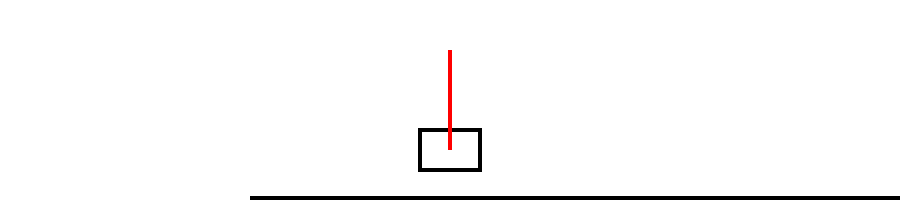

In [55]:
from IPython.display import SVG

scale = 50

SVG(f"""<svg width="900" height="200" viewBox="-200 -150 400 200">
<g stroke-width="4">
<animateTransform attributeName="transform"
                          type="translate"
                          values="{";".join((y[0]*scale).astype(str))}"
                          dur="{T}s"
                          repeatCount="indefinite"/>
<rect x="-30" y="-20" width="60" height="40" fill="transparent" stroke="black" >
</rect>
<line x1="0" x2="0" y1="0" y2="{-l*scale}" stroke="red">
<animateTransform attributeName="transform"
                          type="rotate"
                          values="{";".join((-np.degrees(y[2])).astype(str))}"
                          dur="{T}s"
                          repeatCount="indefinite"/>
</line>
</g>
<rect x="-200" y="46" width="100%" height="4"/>
<rect x="-200" y="46" width="0%" height="4" fill="red"><animate 
                     attributeName="width" 
                     from="0%" 
                     to="100%"
                     dur="{T}s"
                     repeatCount="indefinite"/></rect>
</svg>""")